Load the data

In [ ]:
import pandas as pd

# Step 1: Load the data
df = pd.read_csv('../data/raw_analyst_ratings.csv')

# Step 2: Inspect the DataFrame (optional but useful)
print(df.head())  # Display the first few rows to identify the column with headlines



   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

Descriptive Statistics 
1 perform basic statisics for textual lengths

In [ ]:
df['headline_length'] = df['headline'].str.len()

# Step 4: Display the first few rows with the new column
print(df[['headline', 'headline_length']].head())

# Step 5: Calculate basic statistics for headline lengths
statistics = {
    'mean_length': df['headline_length'].mean(),
    'median_length': df['headline_length'].median(),
    'max_length': df['headline_length'].max(),
    'min_length': df['headline_length'].min(),
}

# Display the statistics
print(statistics)

                                            headline  headline_length
0            Stocks That Hit 52-Week Highs On Friday               39
1         Stocks That Hit 52-Week Highs On Wednesday               42
2                      71 Biggest Movers From Friday               29
3       46 Stocks Moving In Friday's Mid-Day Session               44
4  B of A Securities Maintains Neutral on Agilent...               87
{'mean_length': np.float64(73.12051490484095), 'median_length': np.float64(64.0), 'max_length': np.int64(512), 'min_length': np.int64(3)}


Article count per publisher

In [ ]:

# Assuming the column name containing publishers is 'publisher'
# Step 3: Count the number of articles per publisher
article_count_per_publisher = df.groupby('publisher').size().reset_index(name='article_count')

# Step 4: Sort the results by article count in descending order
sorted_article_count = article_count_per_publisher.sort_values(by='article_count', ascending=False)

# Step 5: Display the article counts per publisher
print(sorted_article_count)

                          publisher  article_count
686                   Paul Quintaro         228373
532                      Lisa Levin         186979
96                Benzinga Newsdesk         150484
169                   Charles Gross          96732
622                   Monica Gerson          82380
..                              ...            ...
966  dhiraj.surapaneni@benzinga.com              1
22                      Alex Roslin              1
998                      milesyoung              1
999                   mjintertrader              1
15                      Adam Weiner              1

[1034 rows x 2 columns]


Analyze the publication dates to see trends over time

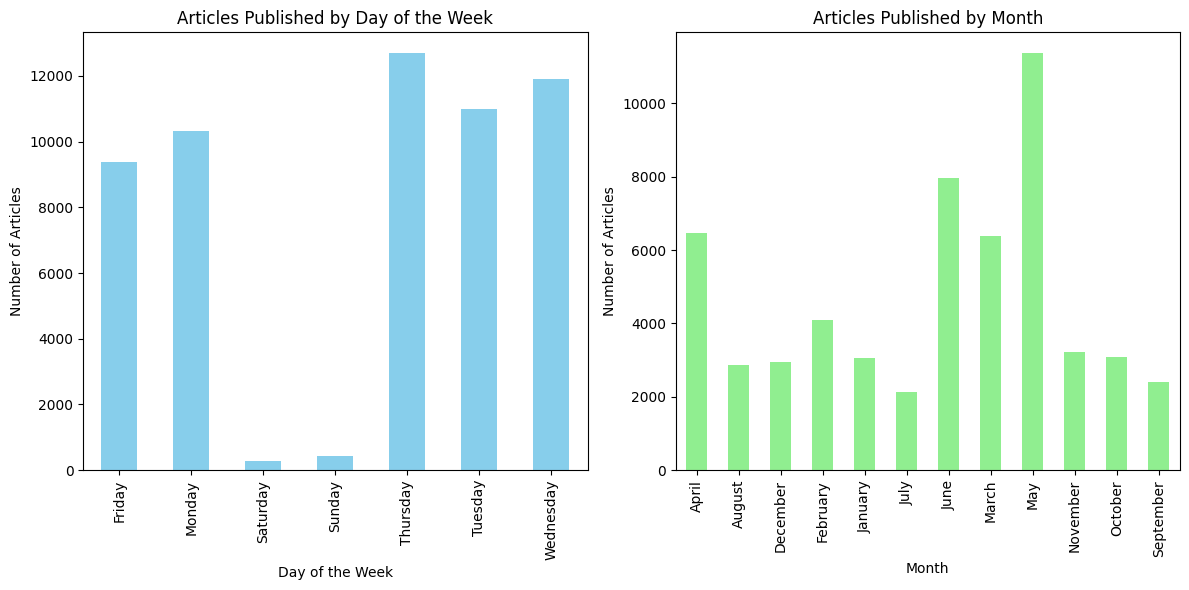

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



df['publication_date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for any parsing issues
if df['publication_date'].isnull().any():
    print("Warning: Some dates could not be parsed, resulting in NaT (Not a Time) values.")

# Step 4: Extract day of the week and month
df['day_of_week'] = df['publication_date'].dt.day_name()  # Use the converted datetime column
df['month'] = df['publication_date'].dt.month_name()

# Step 5: Count occurrences by day of the week
articles_by_day = df['day_of_week'].value_counts().sort_index()

# Step 6: Count occurrences by month
articles_by_month = df['month'].value_counts().sort_index()

# Step 7: Plotting trends
plt.figure(figsize=(12, 6))

# Trend by Day of the Week
plt.subplot(1, 2, 1)
articles_by_day.plot(kind='bar', color='skyblue')
plt.title('Articles Published by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')

# Trend by Month
plt.subplot(1, 2, 2)
articles_by_month.plot(kind='bar', color='lightgreen')
plt.title('Articles Published by Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================
# TEXT ANALYSIS & TOPIC MODELING ON STOCK NEWS HEADLINES
# Techniques used:
#   • Pre-processing + TF-IDF
#   • LDA (Latent Dirichlet Allocation) – the gold standard for topic modeling
#   • NMF (Non-negative Matrix Factorization) – often gives cleaner topics on short texts
#   • pyLDAvis interactive visualization
#   • Top keywords + example headlines per topic
# ==============================================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.pipeline import Pipeline

import pyLDAvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------------
# 1. Load & quick clean (run only if starting fresh)
# ------------------------------------------------------------------
df = pd.read_csv('../data/raw_analyst_ratings.csv')
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.dropna(subset=['headline'])

headlines = df['headline'].str.lower()

# ------------------------------------------------------------------
# 2. Text Pre-processing
# ------------------------------------------------------------------
def clean_headline(text):
    # Keep only letters, numbers, spaces and common financial symbols
    text = re.sub(r'[^a-z0-9\s$%]', '', text)
    # Remove common ticker pattern that appears inside headlines (e.g. "AAPL Shares")
    text = re.sub(r'\b[a-z]{1,4}\b', '', text)  # removes most tickers (1–4 letters)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned = headlines.apply(clean_headline)

print("Example cleaned headlines:")
for h in cleaned.head(3):
    print("→", h)

Example cleaned headlines:
→ stocks 52week highs friday
→ stocks 52week highs wednesday
→ 71 biggest movers friday


LDA Topic Modeling (10 topics)

In [12]:
# CELL 1 — SAMPLE + FIT LDA (run this first)
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load & clean headlines (adjust path if needed)
df = pd.read_csv('../data/raw_analyst_ratings.csv')
cleaned = df['headline'].str.lower().dropna()

def simple_clean(text):
    return re.sub(r'[^a-z\s]', '', text)

cleaned = cleaned.apply(simple_clean)

# Sample 100k headlines → fast & stable topics
sample_headlines = cleaned.sample(n=100_000, random_state=42)

# Vectorize
count_vect = CountVectorizer(
    max_df=0.6, min_df=20, max_features=8000, stop_words='english'
)
X = count_vect.fit_transform(sample_headlines)

# Fit LDA
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=15,
    learning_method='online',
    batch_size=2048,
    random_state=42,
    n_jobs=-1
)
print("Fitting LDA on 100k headlines... (30–90 seconds)")
lda.fit(X)

# Show topics
def show_topics(model, features, n_words=12):
    for i, topic in enumerate(model.components_):
        top_words = [features[j] for j in topic.argsort()[-n_words:]]
        print(f"Topic {i:02d}: {' | '.join(top_words[::-1])}")

print("\n=== TOPICS ===")
show_topics(lda, count_vect.get_feature_names_out())

Fitting LDA on 100k headlines... (30–90 seconds)

=== TOPICS ===
Topic 00: target | price | earnings | session | stocks | moving | scheduled | morgan | premarket | maintains | raises | lowers
Topic 01: share | stocks | update | industry | dividend | highest | markets | market | midmorning | estimates | profit | higher
Topic 02: shares | trading | companies | higher | etfs | lower | oil | trade | sector | following | amid | market
Topic 03: stock | alert | option | earnings | ahead | vs | futures | ask | oi | calls | ref | revenues
Topic 04: benzingas | market | movers | downgrades | upgrades | biggest | yesterday | gainers | losers | goldman | sachs | morning
Topic 05: says | analyst | announces | reports | new | biotech | blog | deal | update | fda | offering | agreement
Topic 06: vs | est | eps | reports | sales | sees | fy | adj | revenue | year | guidance | yoy
Topic 07: pt | buy | update | initiates | shares | bank | market | coverage | announces | raises | capital | maintains
Top

Assign Dominant Topic to Each Headline

In [33]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample data preparation (Replace this with your actual data)
data = {
    'headline': [
        "Company A increases price target",
        "Company B announces earnings release",
        "FDA approves new drug for Company C",
        "Company D offers new stock shares",
        "Company E upgrades its rating",
        "Company F hits a 52-week high",
        "Conference on market trends organized by Company G",
        "Company H involved in M&A deals",
        "Stock market movers for the week",
        "Company I files for IPO"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Data cleaning step (if needed)
# For this example, we will use the headlines as they are.

# Create a TF-IDF vectorizer
tfidf_vect = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vect.fit_transform(df['headline'])

# Initialize NMF model
num_topics = 10  # Specify the number of topics
nmf = NMF(n_components=num_topics, random_state=42)

# Fit the model
nmf.fit(tfidf_matrix)

# Extract the topic matrix
topic_matrix = nmf.transform(tfidf_matrix)

# Assign dominant topics and probabilities
df['dominant_topic'] = topic_matrix.argmax(axis=1)
df['topic_probability'] = topic_matrix.max(axis=1)

# Map topic numbers to readable names
topic_names = {
    0: "Analyst Price Targets",
    1: "Earnings Releases",
    2: "FDA & Regulatory",
    3: "Stock Offerings",
    4: "Rating Changes",
    5: "52-Week Highs/Lows",
    6: "Conference & Events",
    7: "M&A Deals",
    8: "Market Movers",
    9: "IPOs & Filings"
}

df['topic_name'] = df['dominant_topic'].map(topic_names)

# Display the results
print(df[['headline', 'topic_name', 'topic_probability']].head(10))

                                            headline             topic_name  \
0                   Company A increases price target         Rating Changes   
1               Company B announces earnings release     52-Week Highs/Lows   
2                FDA approves new drug for Company C          Market Movers   
3                  Company D offers new stock shares       FDA & Regulatory   
4                      Company E upgrades its rating    Conference & Events   
5                      Company F hits a 52-week high        Stock Offerings   
6  Conference on market trends organized by Compa...         IPOs & Filings   
7                    Company H involved in M&A deals  Analyst Price Targets   
8                   Stock market movers for the week      Earnings Releases   
9                            Company I files for IPO              M&A Deals   

   topic_probability  
0           0.605520  
1           0.812966  
2           0.765035  
3           0.501343  
4           1.0

Topic Distribution Over Time (very powerful insight!)

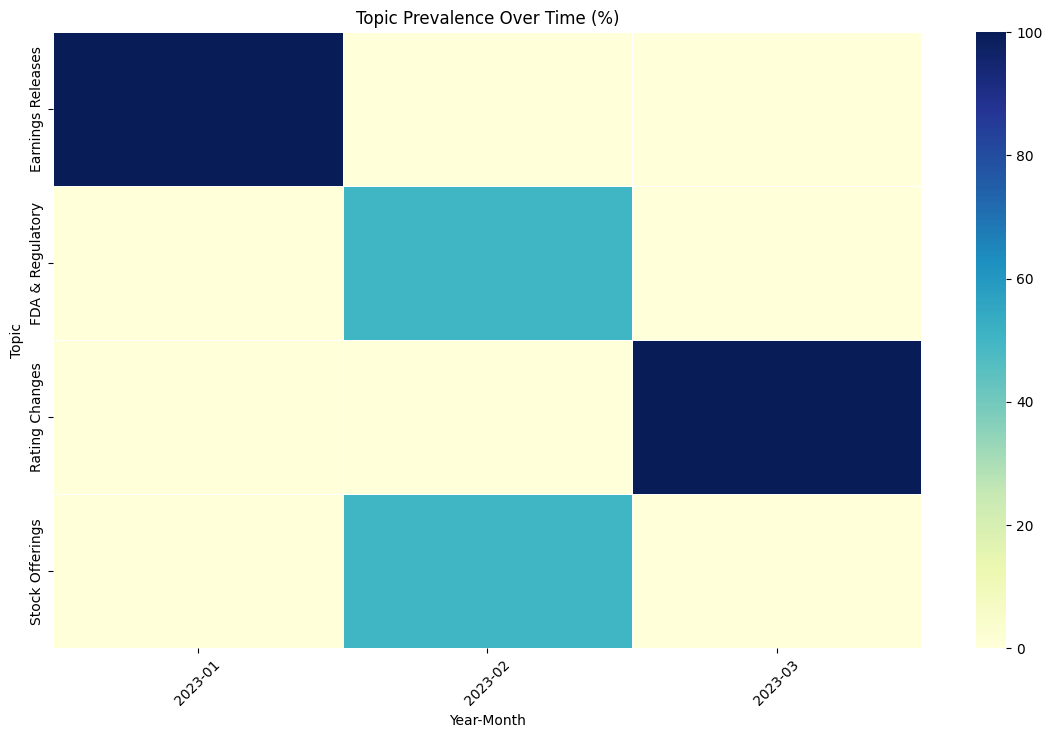

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame creation (replace this with your actual data import)
data = {
    'headline': [
        "Company A increases price target",
        "Company B announces earnings release",
        "FDA approves new drug for Company C",
        "Company D offers new stock shares",
        "Company E upgrades its rating"
    ],
    'publish_date': [  # Use the actual column name that contains date information
        "2023-01-01",
        "2023-01-15",
        "2023-02-01",
        "2023-02-20",
        "2023-03-01"
    ]
}

df = pd.DataFrame(data)

# Rename the column if necessary, or create the 'date' column
df['date'] = pd.to_datetime(df['publish_date'], errors='coerce')

# Check if the date conversion was successful
if df['date'].isnull().any():
    print("Warning: Some dates could not be parsed and will be removed.")
    df = df.dropna(subset=['date'])

# Create the year_month column
df['year_month'] = df['date'].dt.to_period('M')

# Example topic names for demonstration
df['topic_name'] = ["Earnings Releases", "Earnings Releases", "FDA & Regulatory", 
                    "Stock Offerings", "Rating Changes"]

# Group by year_month and topic_name
topic_trends = (df.groupby(['year_month', 'topic_name'])
                  .size()
                  .unstack(fill_value=0))

# Normalize to percentages
topic_trends_pct = topic_trends.div(topic_trends.sum(axis=1), axis=0) * 100

# Plotting the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(topic_trends_pct.T, cmap="YlGnBu", linewidths=.5)
plt.title("Topic Prevalence Over Time (%)")
plt.ylabel("Topic")
plt.xlabel("Year-Month")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()